## Simulation and POD analysis of the marginally turbulent flow in an open channel at low Reynolds number using `Nek5000`
> Saleh Rezaeiravesh and Philipp Schlatter <br />
  salehr@mech.kth.se, pschlatt@mech.kth.se <br />
  SimEx/FLOW, KTH Engineering Mechanics, Royal Institute of Technology, Stockholm, Sweden

This is a short tutorial for the simulation of the turbulent flow in an open channel at low Reynolds number ($Re_b=2000$), and the analysis of the velocity fields using 3D POD.

The streamwise, wall-normal, and spanwise coordinates are specified by $x$, $y$, and $z$, respectively. The flow is periodic in both $x$ and $z$ directions. The lower boundary condition at $y=0$ is a solid wall (no slip boundary condition) and at $y=1$ a slip condition ($\partial u/\partial y=v=\partial w/\partial y = 0$). 

## 1. Nek5000 source code and POD

We use the standard `Nek5000` code which can be cloned from [here](https://github.com/Nek5000/Nek5000). If you want you can also use the KTH-Framework extension of `Nek5000` which can be cloned from [here](https://github.com/KTH-Nek5000/KTH_Framework). 

The source files of the minimal channel can be downloaded from [here](https://github.com/KTH-Nek5000/TurbCourse/tree/main/minimal_channel). You will need `channel.box`, `SIZE`, `channel.usr` and `channel.par`.

The POD code can be downloaded from [here](https://github.com/KTH-Nek5000/TurbCourse/tree/main/pod). Do not use the pip version of the Nek readers.

## 2. Flow simulation

The case is called `channel`. In the following, different steps are briefly explained to set up and run the simulation as well as computing POD. 

### 2.1. Mesh Generation & Specifying Boundary Conditions (OLD)

We use the internal mesh generator of `Nek5000` to create a uniform mesh for a 3D square box. Then, in the `.usr` file, the coordinates of the points of the geometry and mesh are adjusted at the first time step to obtain the geomtery of the periodic hill with a structured mesh. 

- In `phill.box`, the size of the box, and mesh size are set:
  * Line 17: Number of elements in $x$, $y$, and $z$ directions. 
  * Lines 18-20: Starting location, final location, and grading of the mesh elements in $x$, $y$, and $z$. 
  * Line 21: Boundary conditions of the six faces of the box with normals in $-x$, $+x$, $-y$, $+y$, $-z$, and $+z$ are respectively set as: `P  ,P  ,W  ,W  ,P  ,P  `, where, `W`=wall, `P`=periodic. 
  
- To create the box and its mesh: run `genbox` which is a `Nek5000` standard tool. This results in `box.re2`. Rename this file as `phill.re2`.

- Map the mesh by `genmap` and create `phill.ma2`. 

When `Nek5000` is compiled and run, the box is mapped into a 3D periodic hill. This is achieved by calling subroutine `box2phill` in `usrdat2` in `phill.usr`. The dimension of the periodic hill geomtery as well as the mesh stretching parameters in the wall-normal directions are specified in subtourine `usrdat2`. 

Since the flow is periodic in the streamwise direction, a forcing term is required to keep the mass flow rate constant at each time step during the simulation. The associated bulk velocity (streamwise velocity averaged over the volume of the whole domain) is computed in subroutine `usrdat3`. 

<img src="./static_figs/phill_mesh.png" alt="drawing" width="600"/>



<center>The mesh created by Nek5000 for the periodic hill geometry.</center>


### 2.2. Compilation

- First, the following should be set in `SIZE`:
    * `lx1`: Number of Gauss-Lobatto-Legendre (GLL) points per element per dimension. 
    * `lxd`: Number of quadrature points for dealiasing (over-integration). We take the integer part of $lxd=3/2\, lx1$.
    * `lelg`: Total number of elements which is obtained from what is set in `channel.box`. This parameter is allowed to be set to a larger value than the actual number of elements, but not less! 
    * `lelt`: Maximum total number of elements per MPI rank. This value can be set considering the minimum MPI rank to be used to run the case. 
    The rest of parameters are kept as default. 

- Next, we need to set the required parameters in the compilation script `compile_script`:
    * Set the absolute path to `Nek5000` source code in `NEK_SOURCE_ROOT`.
    * Set appropriate FORTRAN and C compilers to `FC` and `CC`, respectively. The default is `FC=mpifort` and `CC=mpicc`. 
    
To compile, run `./compile_script --all`. The compilation report will be written in `build.log`.

For cleaning old compilation files, run `./compile_script --clean` and then type `Y`.     

### 2.3. Running the case

After compiling the case, the object file `nek5000` is created which can be executed. To run the case with, for instance, 4 processors, type

`mpirun -np 4 nek5000 >>logfile&`

However, prior to this, two things should be done:

1. Create a file named `SESSION.NAME`. The first line is the case name, i.e. `channel` and the second line is the absolute path to the case directory (do not forget `/` at the end of the path).

2. Set the simulation parameters in `channel.par`. The parameters include:
   * Maximum number of time steps `numSteps`
   * Time step size, `dt`. For a constant $\Delta t$ set a negative value, a positive one gives the maximum
   * Interval of saving flow fields `writeInterval`
   * Reynolds number or viscosity, `viscosity`. If a negative value is set, it will be considered as the Reynolds number. 

List of the output files:
   * `channel0.f*`: snapshots of the flow fields written at intervals `writeInterval`.

**Contour plots of the snapshots:**
The snapshot fields `channel0.f*` can be plotted using [`ParaView`](https://www.paraview.org/) or [`VisIt`](https://wci.llnl.gov/simulation/computer-codes/visit). To this end, we need to first run `visnek` command in the case root. This creates `channel.nek5000` which can be opened in the mentioned software. 

<img src="static_figs/phill_vel.png" width="500"/>

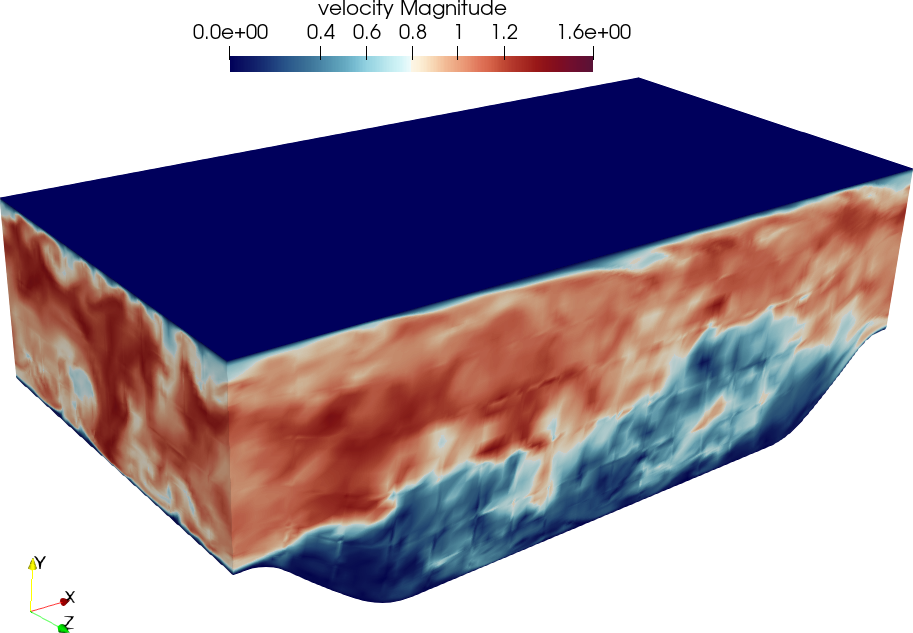

<center>Contours of an instantaneous field of velocity magnitude.</center>

Note that this case may be run for longer than the given example ($t_\mathrm{max} = 500$). However, as always with minimal channels there is a chance of re-laminarising.

## 3. POD analysis